In [29]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [30]:
plt.rcParams.update({
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 16
})

  # Configuration

In [31]:
# ========================================
# CATEGORY TOGGLES
# ========================================
USE_4_CATEGORIES = False  # background categories: if True, split NaN out of Comb

# Phase 1: DO NOT apply photon-conversion veto
APPLY_GAMMA_VETO = False
GAMMAVETO_THRESHOLD = 0.1  # kept for later phases, not used now

In [32]:
# Define decay modes, trees, and D0 mass window cuts
decay_config = {
    'kmpip': {
        'ds_tree': 'DstreeCh1',
        'cut': "(-0.014291 <= D0_dM) & (D0_dM <= 0.014152)"
    },
    'km3pi': {
        'ds_tree': 'DstreeCh3',
        'cut': "(-0.013093 <= D0_dM) & (D0_dM <= 0.012520)"
    },
    'kmpippi0_eff20_May2020': {
        'ds_tree': 'DstreeCh2',
        'cut': "(-0.052152 <= D0_dM) & (D0_dM <= 0.024237)"
    }
}

# Background samples
background_samples = ["ccbar", "charged", "ddbar", "mixed", "ssbar", "uubar"]

  # Prep-Work

  ### Import Data

In [33]:
DataFrames = {}  # dictionary to hold dataframes

print("Loading Signal files...")
for mode, config in tqdm(list(decay_config.items()), desc="Signal modes"):
    signal_file = f"/home/belle2/amubarak/C01-Simulated_Events/Signal/output_test_{mode}.root"
    df = uproot.concatenate(f"{signal_file}:{config['ds_tree']}", library='pd')
    df = df.query(config['cut'])
    DataFrames[f"Signal_{mode}"] = df

print("\nLoading Background files...")
for sample in tqdm(background_samples, desc="Background samples"):
    for mode, config in decay_config.items():
        generic_file = f"/group/belle/users/amubarak/03-KEKCC/Ds2D0e-Generic_Ds_120325_1_{sample}_{mode}.root"
        df = uproot.concatenate(f"{generic_file}:{config['ds_tree']}", library='pd')
        df = df.query(config['cut'])
        DataFrames[f"{sample}_{mode}"] = df

print("\nCombining background samples by mode...")
for mode in decay_config.keys():
    dfs_list = [DataFrames[f"{sample}_{mode}"] for sample in background_samples]
    DataFrames[f"All_{mode}"] = pd.concat(dfs_list, ignore_index=True)

print("\nData loading complete!")
print(f"Successfully loaded {len(DataFrames)} dataframes")
print(f"Using {'4' if USE_4_CATEGORIES else '3'} background categories")
print(f"APPLY_GAMMA_VETO = {APPLY_GAMMA_VETO}")

Loading Signal files...


Signal modes:   0%|          | 0/3 [00:00<?, ?it/s]


Loading Background files...


Background samples:   0%|          | 0/6 [00:00<?, ?it/s]


Combining background samples by mode...

Data loading complete!
Successfully loaded 24 dataframes
Using 3 background categories
APPLY_GAMMA_VETO = False


In [34]:
pd.set_option('display.max_rows', 200000)
pd.set_option('display.max_columns', 200000)

 # PRELIMINARY RESULTS
 ---

  ## Value Counts - Ds_mcPDG

  ### Signal Samples: Ds_mcPDG and Ds* ancestry checks

In [35]:
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"Signal_{mode} : abs(Ds_mcPDG) fractions")
    print('='*80)
    df_sig = DataFrames[f"Signal_{mode}"]
    print(abs(df_sig['Ds_mcPDG']).value_counts(normalize=True, dropna=False)
          .apply(lambda x: f"{x:.6f}"))

    # D*+ ancestry checks for Ds_mcPDG = 433
    mask_dsstar = abs(df_sig['Ds_mcPDG']) == 433
    df_dsstar = df_sig[mask_dsstar]

    if len(df_dsstar) > 0:
        print(f"\n  D0_genMotherPDG for |Ds_mcPDG| = 433 (Signal_{mode})")
        if 'D0_genMotherPDG' in df_dsstar.columns:
            print(abs(df_dsstar['D0_genMotherPDG']).value_counts(normalize=True, dropna=False)
                  .apply(lambda x: f"{x:.6f}").head(20))
        else:
            print("  Column D0_genMotherPDG not found")

        print(f"\n  e_genMotherPDG for |Ds_mcPDG| = 433 (Signal_{mode})")
        if 'e_genMotherPDG' in df_dsstar.columns:
            print(abs(df_dsstar['e_genMotherPDG']).value_counts(normalize=True, dropna=False)
                  .apply(lambda x: f"{x:.6f}").head(20))
        else:
            print("  Column e_genMotherPDG not found")
    else:
        print("\n  No entries with |Ds_mcPDG| = 433 in Signal_{mode}")


Signal_kmpip : abs(Ds_mcPDG) fractions
Ds_mcPDG
431.0      0.877374
23.0       0.089897
433.0      0.016757
NaN        0.011373
10431.0    0.001815
20433.0    0.001452
413.0      0.000907
423.0      0.000423
Name: proportion, dtype: object

  D0_genMotherPDG for |Ds_mcPDG| = 433 (Signal_kmpip)
D0_genMotherPDG
431.0    1.000000
Name: proportion, dtype: object

  e_genMotherPDG for |Ds_mcPDG| = 433 (Signal_kmpip)
e_genMotherPDG
22.0     0.675090
433.0    0.299639
111.0    0.025271
Name: proportion, dtype: object

Signal_km3pi : abs(Ds_mcPDG) fractions
Ds_mcPDG
431.0      0.803429
23.0       0.149796
NaN        0.023347
433.0      0.017143
413.0      0.002204
20433.0    0.001551
10431.0    0.001061
421.0      0.000735
423.0      0.000653
10413.0    0.000082
Name: proportion, dtype: object

  D0_genMotherPDG for |Ds_mcPDG| = 433 (Signal_km3pi)
D0_genMotherPDG
431.0    0.976190
23.0     0.023810
Name: proportion, dtype: object

  e_genMotherPDG for |Ds_mcPDG| = 433 (Signal_km3pi)
e_genMoth

  ### Background Samples (Combined by Mode): Ds_mcPDG and Ds* ancestry

In [36]:
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"All_{mode} (ccbar + charged + ddbar + mixed + ssbar + uubar)")
    print('='*80)
    df_bkg = DataFrames[f"All_{mode}"]
    print(abs(df_bkg['Ds_mcPDG']).value_counts(normalize=True, dropna=False)
          .apply(lambda x: f"{x:.6f}"))

    mask_dsstar = abs(df_bkg['Ds_mcPDG']) == 433
    df_dsstar_bkg = df_bkg[mask_dsstar]

    if len(df_dsstar_bkg) > 0:
        print(f"\n  D0_genMotherPDG for |Ds_mcPDG| = 433 (All_{mode})")
        if 'D0_genMotherPDG' in df_dsstar_bkg.columns:
            print(abs(df_dsstar_bkg['D0_genMotherPDG']).value_counts(normalize=True, dropna=False)
                  .apply(lambda x: f"{x:.6f}").head(20))
        else:
            print("  Column D0_genMotherPDG not found")

        print(f"\n  e_genMotherPDG for |Ds_mcPDG| = 433 (All_{mode})")
        if 'e_genMotherPDG' in df_dsstar_bkg.columns:
            print(abs(df_dsstar_bkg['e_genMotherPDG']).value_counts(normalize=True, dropna=False)
                  .apply(lambda x: f"{x:.6f}").head(20))
        else:
            print("  Column e_genMotherPDG not found")
    else:
        print("\n  No entries with |Ds_mcPDG| = 433 in All_{mode}")


All_kmpip (ccbar + charged + ddbar + mixed + ssbar + uubar)
Ds_mcPDG
23.0        0.569825
NaN         0.218676
413.0       0.136574
423.0       0.052709
300553.0    0.007272
20413.0     0.002925
10411.0     0.002260
415.0       0.001981
425.0       0.001433
10421.0     0.001345
10413.0     0.001254
20423.0     0.001242
10423.0     0.000890
435.0       0.000603
421.0       0.000480
10433.0     0.000387
411.0       0.000043
213.0       0.000040
4122.0      0.000017
113.0       0.000011
431.0       0.000009
433.0       0.000006
4132.0      0.000006
521.0       0.000006
4214.0      0.000003
4232.0      0.000003
4224.0      0.000003
Name: proportion, dtype: object

  D0_genMotherPDG for |Ds_mcPDG| = 433 (All_kmpip)
D0_genMotherPDG
433.0    1.000000
Name: proportion, dtype: object

  e_genMotherPDG for |Ds_mcPDG| = 433 (All_kmpip)
e_genMotherPDG
22.0    1.000000
Name: proportion, dtype: object

All_km3pi (ccbar + charged + ddbar + mixed + ssbar + uubar)
Ds_mcPDG
23.0        0.603900
NaN    

  ### Individual Background Samples (quick Ds_mcPDG overview)

In [37]:
for sample in background_samples:
    print(f"\n{'='*80}")
    print(f"{sample.upper()}")
    print('='*80)
    for mode in decay_config.keys():
        key = f"{sample}_{mode}"
        print(f"\n  {key}:")
        print(f"  {'-'*76}")
        df = DataFrames[key]
        print(abs(df['Ds_mcPDG']).value_counts(normalize=True, dropna=False)
              .head(10)
              .apply(lambda x: f"{x:.6f}"))


CCBAR

  ccbar_kmpip:
  ----------------------------------------------------------------------------
Ds_mcPDG
23.0       0.556110
NaN        0.213260
413.0      0.154274
423.0      0.059538
20413.0    0.003304
10411.0    0.002553
415.0      0.002238
425.0      0.001618
10421.0    0.001519
10413.0    0.001416
Name: proportion, dtype: object

  ccbar_km3pi:
  ----------------------------------------------------------------------------
Ds_mcPDG
23.0       0.611760
NaN        0.216383
413.0      0.116048
423.0      0.039847
20413.0    0.002572
415.0      0.002148
10411.0    0.002093
421.0      0.001781
425.0      0.001424
20423.0    0.001365
Name: proportion, dtype: object

  ccbar_kmpippi0_eff20_May2020:
  ----------------------------------------------------------------------------
Ds_mcPDG
23.0       0.567953
NaN        0.286505
413.0      0.092421
423.0      0.037204
20413.0    0.002956
415.0      0.002152
10411.0    0.002119
421.0      0.002077
425.0      0.001241
10421.0    0.001123


 ## Yield / cutflow summary (Phase 1, no gamma veto)

In [38]:
for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"Yield summary - {mode}")
    print('='*80)

    # Signal categories based on Ds_mcPDG
    df_sig = DataFrames[f"Signal_{mode}"].copy()
    ds_abs = abs(df_sig['Ds_mcPDG'])

    mask_ds   = ds_abs == 431
    mask_dsst = ds_abs == 433
    mask_nan  = df_sig['Ds_mcPDG'].isna()
    mask_other = (~mask_ds) & (~mask_dsst) & (~mask_nan)

    print("Signal sample:")
    print(f"  total rows           : {len(df_sig)}")
    print(f"  |Ds_mcPDG| == 431    : {mask_ds.sum()} (true Ds+)")
    print(f"  |Ds_mcPDG| == 433    : {mask_dsst.sum()} (Ds*+)")
    print(f"  Ds_mcPDG is NaN      : {mask_nan.sum()}")
    print(f"  other Ds_mcPDG       : {mask_other.sum()} (combinatorial/misreco)")

    # Background categories
    df_bkg = DataFrames[f"All_{mode}"].copy()
    bkg_abs = abs(df_bkg['Ds_mcPDG'])

    mask_dsp  = bkg_abs == 413
    mask_ds0  = bkg_abs == 423
    mask_nan_b = df_bkg['Ds_mcPDG'].isna()
    mask_comb = (~mask_dsp) & (~mask_ds0)

    print("\nBackground sample (All):")
    print(f"  total rows           : {len(df_bkg)}")
    print(f"  |Ds_mcPDG| == 413    : {mask_dsp.sum()} (D*+)")
    print(f"  |Ds_mcPDG| == 423    : {mask_ds0.sum()} (D*0)")
    print(f"  Ds_mcPDG is NaN      : {mask_nan_b.sum()}")
    print(f"  comb (not 413/423)   : {mask_comb.sum()}")


Yield summary - kmpip
Signal sample:
  total rows           : 16530
  |Ds_mcPDG| == 431    : 14503 (true Ds+)
  |Ds_mcPDG| == 433    : 277 (Ds*+)
  Ds_mcPDG is NaN      : 188
  other Ds_mcPDG       : 1562 (combinatorial/misreco)

Background sample (All):
  total rows           : 351780
  |Ds_mcPDG| == 413    : 48044 (D*+)
  |Ds_mcPDG| == 423    : 18542 (D*0)
  Ds_mcPDG is NaN      : 76926
  comb (not 413/423)   : 285194

Yield summary - km3pi
Signal sample:
  total rows           : 12250
  |Ds_mcPDG| == 431    : 9842 (true Ds+)
  |Ds_mcPDG| == 433    : 210 (Ds*+)
  Ds_mcPDG is NaN      : 286
  other Ds_mcPDG       : 1912 (combinatorial/misreco)

Background sample (All):
  total rows           : 809611
  |Ds_mcPDG| == 413    : 74416 (D*+)
  |Ds_mcPDG| == 423    : 25552 (D*0)
  Ds_mcPDG is NaN      : 179285
  comb (not 413/423)   : 709643

Yield summary - kmpippi0_eff20_May2020
Signal sample:
  total rows           : 9717
  |Ds_mcPDG| == 431    : 6863 (true Ds+)
  |Ds_mcPDG| == 433    :

  ## Basic Distribution Plots
  ### Signal Plots (Ds_mcPDG-based categories, no gamma veto)


Signal kmpip, Ds_diff_D0pi, Width Per Bin: 12.00 MeV


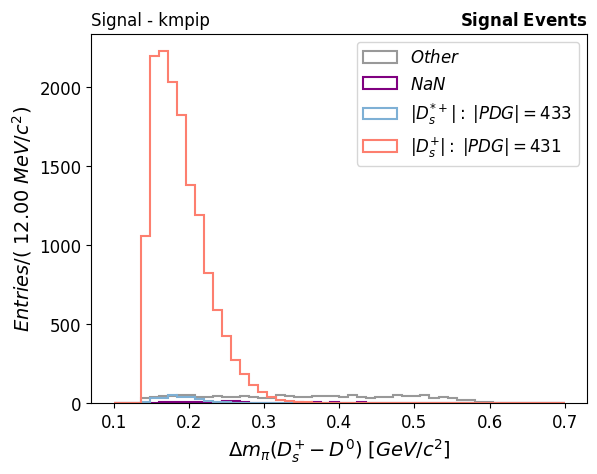


Signal km3pi, Ds_diff_D0pi, Width Per Bin: 12.00 MeV


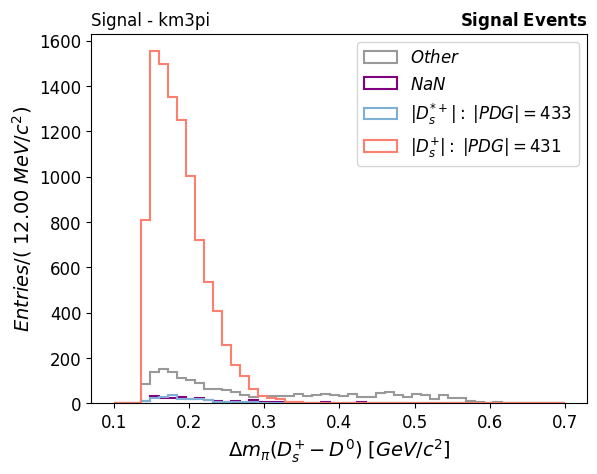


Signal kmpippi0_eff20_May2020, Ds_diff_D0pi, Width Per Bin: 12.00 MeV


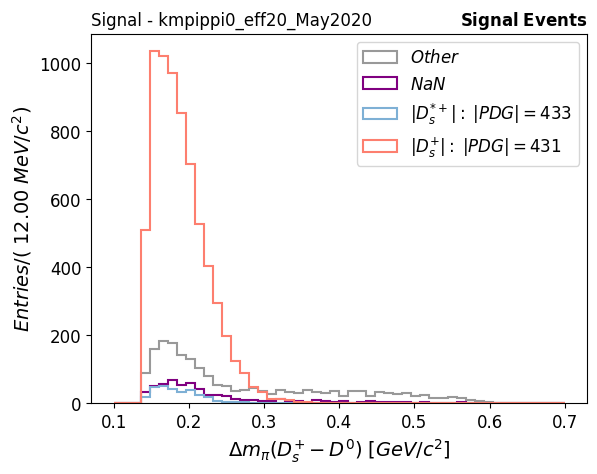

In [39]:
Bins = 50
Density = False
Stacked = False

# Plot Signal - Ds_diff_D0pi
Range = [0.1, 0.7]
var = 'Ds_diff_D0pi'

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nSignal {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"Signal_{mode}"].copy()
    ds_abs = abs(df['Ds_mcPDG'])

    ds_mask   = ds_abs == 431
    dsst_mask = ds_abs == 433
    nan_mask  = df['Ds_mcPDG'].isna()
    other_mask = (~ds_mask) & (~dsst_mask) & (~nan_mask)

    data = [
        df[ds_mask][var],        # Ds+
        df[dsst_mask][var],      # Ds*+
        df[nan_mask][var],       # NaN
        df[other_mask][var]      # other
    ]

    labels = [
        r'$|D_s^{+}|:\;|PDG|=431$',
        r'$|D_s^{*+}|:\;|PDG|=433$',
        r'$NaN$',
        r'$Other$'
    ]
    colors = ['#fd7f6f', '#7eb0d5', 'purple', '#999999']

    plt.hist(
        data,
        color=colors,
        label=labels,
        alpha=1,
        range=Range,
        stacked=Stacked,
        density=Density,
        bins=Bins,
        histtype='step',
        linewidth=1.5
    )

    plt.title(f'Signal - {mode}', loc="left")
    plt.title(r'$\bf Signal\;Events$', loc="right")
    plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width=perBin))
    plt.xlabel(r'$\Delta m_{\pi}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
    plt.legend()
    plt.show()


Signal kmpip, Ds_massDifference_0, Width Per Bin: 5.00 MeV


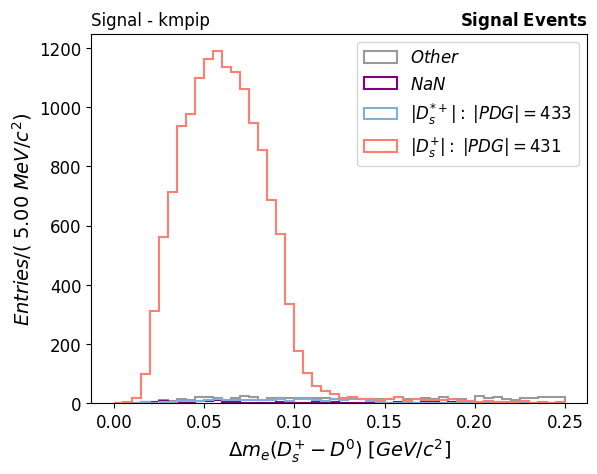


Signal km3pi, Ds_massDifference_0, Width Per Bin: 5.00 MeV


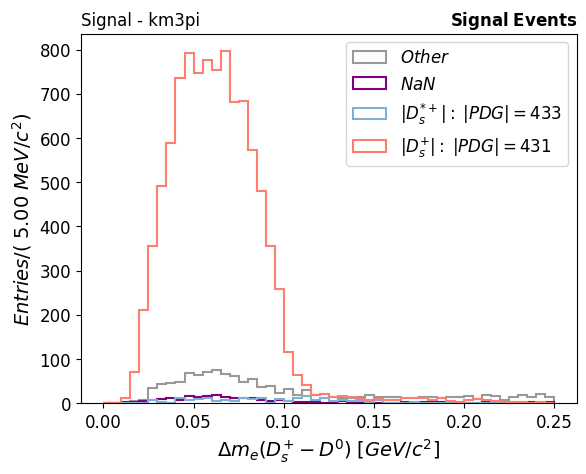


Signal kmpippi0_eff20_May2020, Ds_massDifference_0, Width Per Bin: 5.00 MeV


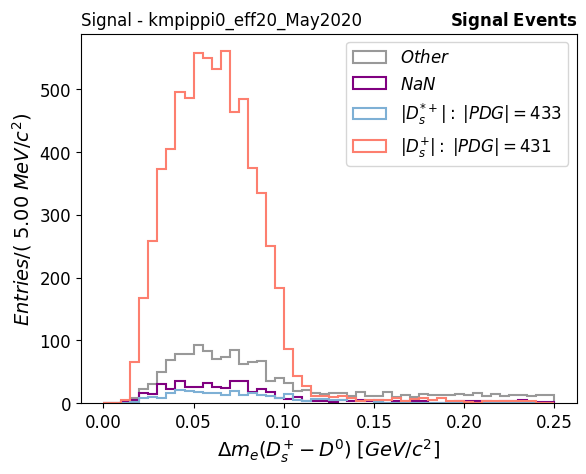

In [40]:
# Plot Signal - Ds_massDifference_0
Bins = 50
Density = False
Stacked = False
Range = [0.0, 0.25]
var = 'Ds_massDifference_0'

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nSignal {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"Signal_{mode}"].copy()
    ds_abs = abs(df['Ds_mcPDG'])

    ds_mask   = ds_abs == 431
    dsst_mask = ds_abs == 433
    nan_mask  = df['Ds_mcPDG'].isna()
    other_mask = (~ds_mask) & (~dsst_mask) & (~nan_mask)

    data = [
        df[ds_mask][var],
        df[dsst_mask][var],
        df[nan_mask][var],
        df[other_mask][var]
    ]

    labels = [
        r'$|D_s^{+}|:\;|PDG|=431$',
        r'$|D_s^{*+}|:\;|PDG|=433$',
        r'$NaN$',
        r'$Other$'
    ]
    colors = ['#fd7f6f', '#7eb0d5', 'purple', '#999999']

    plt.hist(
        data,
        color=colors,
        label=labels,
        alpha=1,
        range=Range,
        stacked=Stacked,
        density=Density,
        bins=Bins,
        histtype='step',
        linewidth=1.5
    )

    plt.title(f'Signal - {mode}', loc="left")
    plt.title(r'$\bf Signal\;Events$', loc="right")
    plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width=perBin))
    plt.xlabel(r'$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
    plt.legend()
    plt.show()

  ### Background Plots (D* categories, no gamma veto)


Background kmpip, Ds_diff_D0pi, Width Per Bin: 12.00 MeV


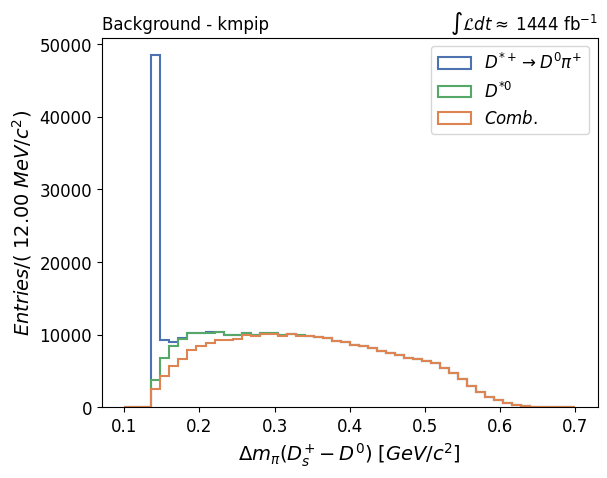


Background km3pi, Ds_diff_D0pi, Width Per Bin: 12.00 MeV


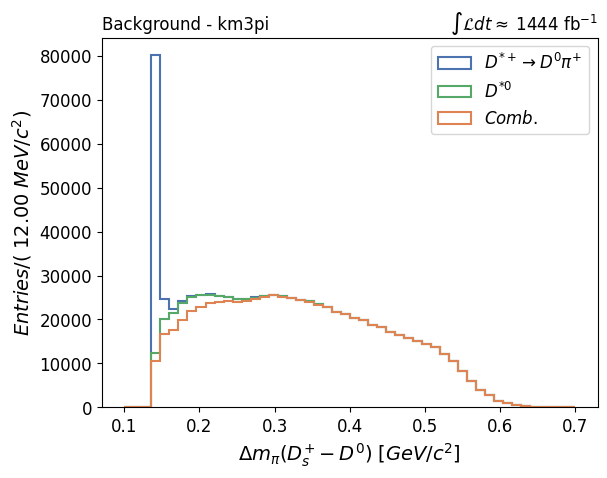


Background kmpippi0_eff20_May2020, Ds_diff_D0pi, Width Per Bin: 12.00 MeV


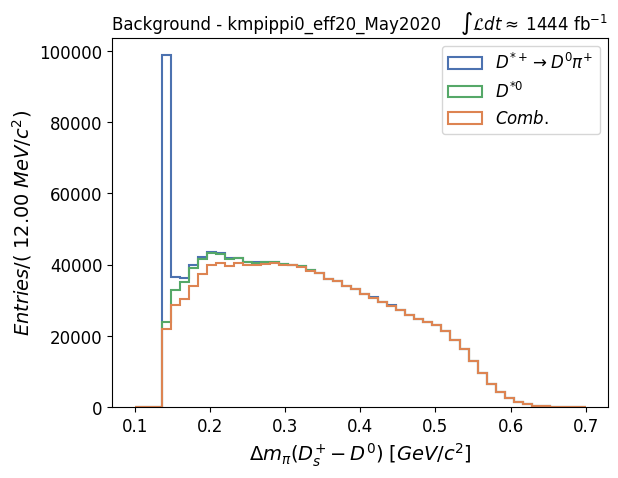

In [41]:
Bins = 50
Density = False
Stacked = True
Range = [0.1, 0.7]
var = 'Ds_diff_D0pi'

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nBackground {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"All_{mode}"].copy()

    if USE_4_CATEGORIES:
        label1 = r'$Comb.$'
        label2 = r'$NaN$'
        label3 = r'$D^{*0}$'
        label4 = r'$D^{*+} \rightarrow D^{0} \pi^{+}$'

        labels = [label1, label2, label3, label4]
        colors = ["#DD8452", "#C44E52", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413) &
               (abs(df["Ds_mcPDG"]) != 423) &
               (~df["Ds_mcPDG"].isna())][var],
            df[df["Ds_mcPDG"].isna()][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var]
        ]
    else:  # 3 categories
        label1 = r'$Comb.$'
        label2 = r'$D^{*0}$'
        label3 = r'$D^{*+} \rightarrow D^{0} \pi^{+}$'

        labels = [label1, label2, label3]
        colors = ["#DD8452", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413) &
               (abs(df["Ds_mcPDG"]) != 423)][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var]
        ]

    plt.hist(
        data,
        color=colors,
        label=labels,
        density=Density,
        stacked=Stacked,
        bins=Bins,
        alpha=1,
        histtype='step',
        linewidth=1.5,
        range=Range
    )

    plt.title(f'Background - {mode}', loc="left")
    plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
    plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width=perBin))
    plt.xlabel(r'$\Delta m_{\pi}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
    plt.legend(loc='upper right')
    plt.show()


Background kmpip, Ds_massDifference_0, Width Per Bin: 5.00 MeV


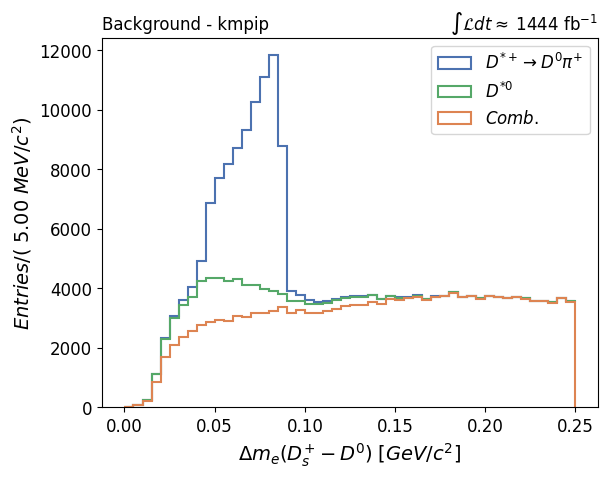


Background km3pi, Ds_massDifference_0, Width Per Bin: 5.00 MeV


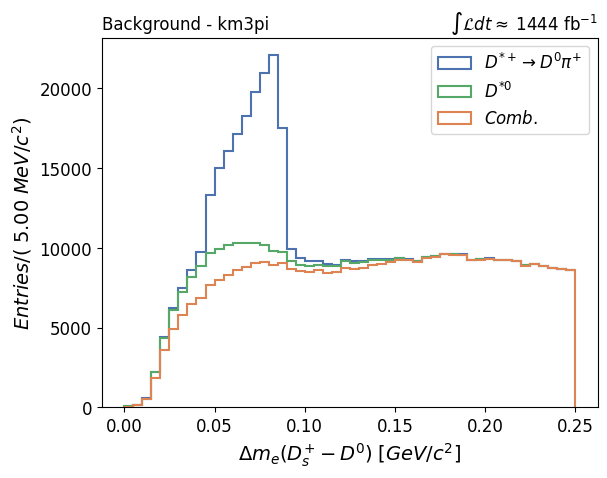


Background kmpippi0_eff20_May2020, Ds_massDifference_0, Width Per Bin: 5.00 MeV


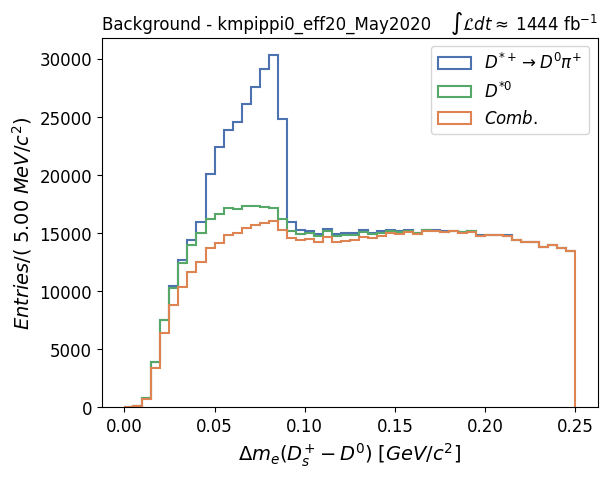

In [42]:
Bins = 50
Density = False
Stacked = True
Range = [0.0, 0.25]
var = 'Ds_massDifference_0'

for mode in decay_config.keys():
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print(f"\nBackground {mode}, {var}, Width Per Bin: {perBin:.2f} MeV")

    df = DataFrames[f"All_{mode}"].copy()

    if USE_4_CATEGORIES:
        label1 = r'$Comb.$'
        label2 = r'$NaN$'
        label3 = r'$D^{*0}$'
        label4 = r'$D^{*+} \rightarrow D^{0} \pi^{+}$'

        labels = [label1, label2, label3, label4]
        colors = ["#DD8452", "#C44E52", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413) &
               (abs(df["Ds_mcPDG"]) != 423) &
               (~df["Ds_mcPDG"].isna())][var],
            df[df["Ds_mcPDG"].isna()][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var]
        ]
    else:  # 3 categories
        label1 = r'$Comb.$'
        label2 = r'$D^{*0}$'
        label3 = r'$D^{*+} \rightarrow D^{0} \pi^{+}$'

        labels = [label1, label2, label3]
        colors = ["#DD8452", "#55A868", "#4C72B0"]

        data = [
            df[(abs(df["Ds_mcPDG"]) != 413) &
               (abs(df["Ds_mcPDG"]) != 423)][var],
            df[abs(df["Ds_mcPDG"]) == 423][var],
            df[abs(df["Ds_mcPDG"]) == 413][var]
        ]

    plt.hist(
        data,
        color=colors,
        label=labels,
        density=Density,
        stacked=Stacked,
        bins=Bins,
        alpha=1,
        histtype='step',
        linewidth=1.5,
        range=Range
    )

    plt.title(f'Background - {mode}', loc="left")
    plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
    plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width=perBin))
    plt.xlabel(r'$\Delta m_e(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
    plt.legend(loc='upper right')
    plt.show()

  # DEEP ANALYSIS: Δm_e vs Δm_π SANITY CHECKS (no veto, no gamma veto)

  * **Δm_e** = `Ds_massDifference_0` (electron mass on lepton track)
  * **Δm_π** = `Ds_diff_D0pi` (pion mass on same track)
  * Signal: |Ds_mcPDG| = 431
  * Bkg1: |Ds_mcPDG| = 413 (D*+)
  * Bkg2: |Ds_mcPDG| = 423 (D*0)
  * Bkg3: everything else (combinatorial)


2D Structure (Δm_e, Δm_π) - kmpip


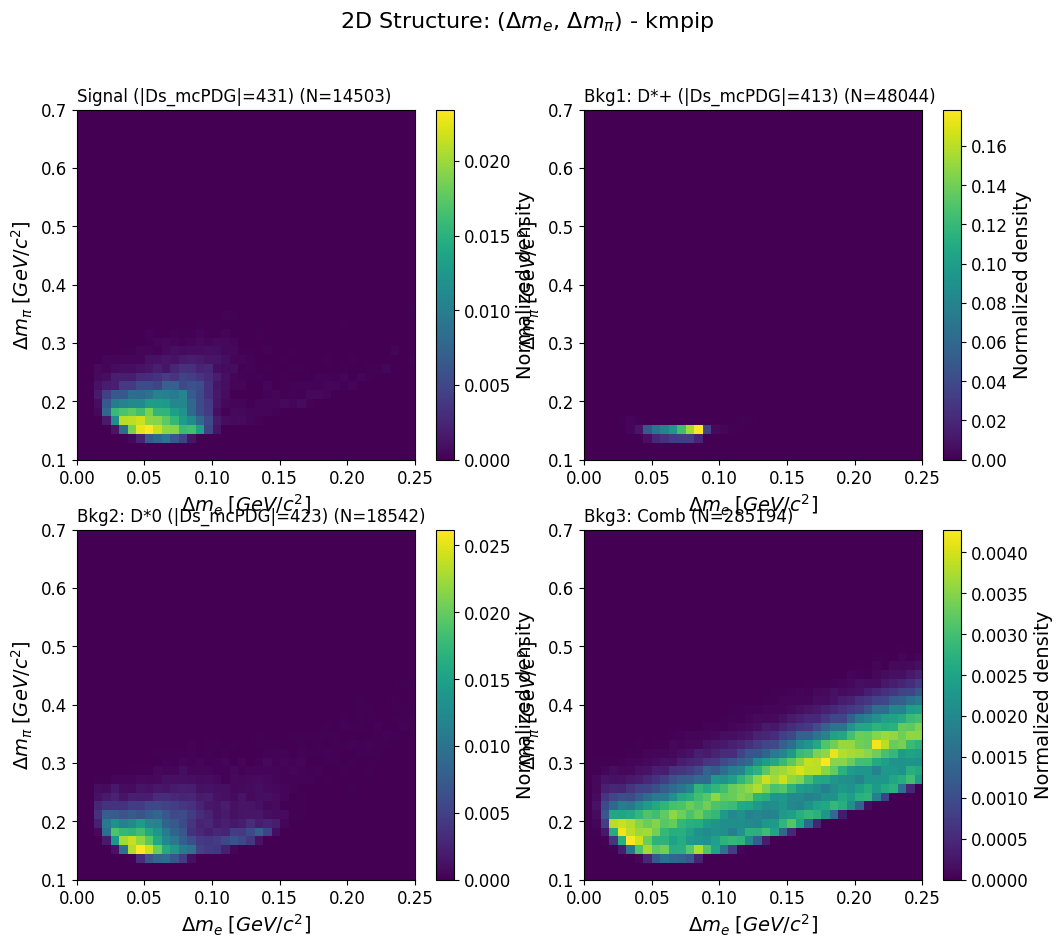


2D Structure (Δm_e, Δm_π) - km3pi


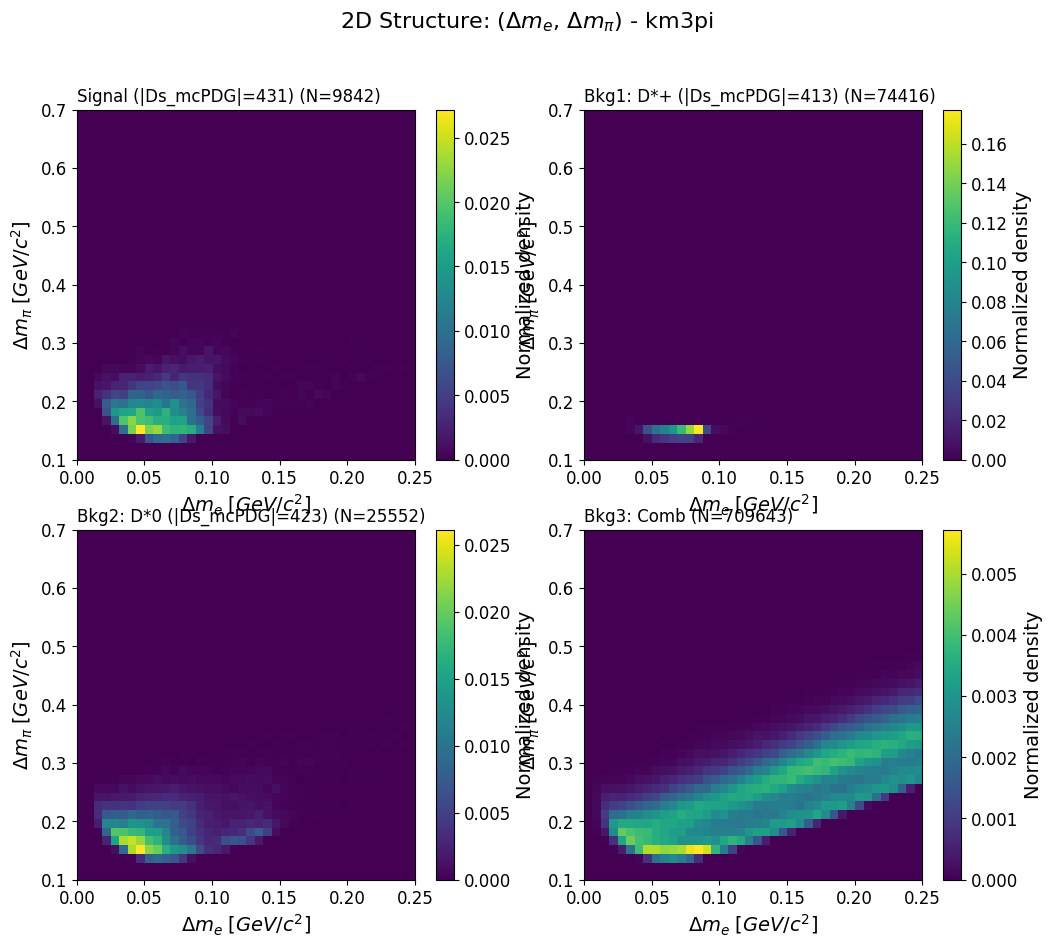


2D Structure (Δm_e, Δm_π) - kmpippi0_eff20_May2020


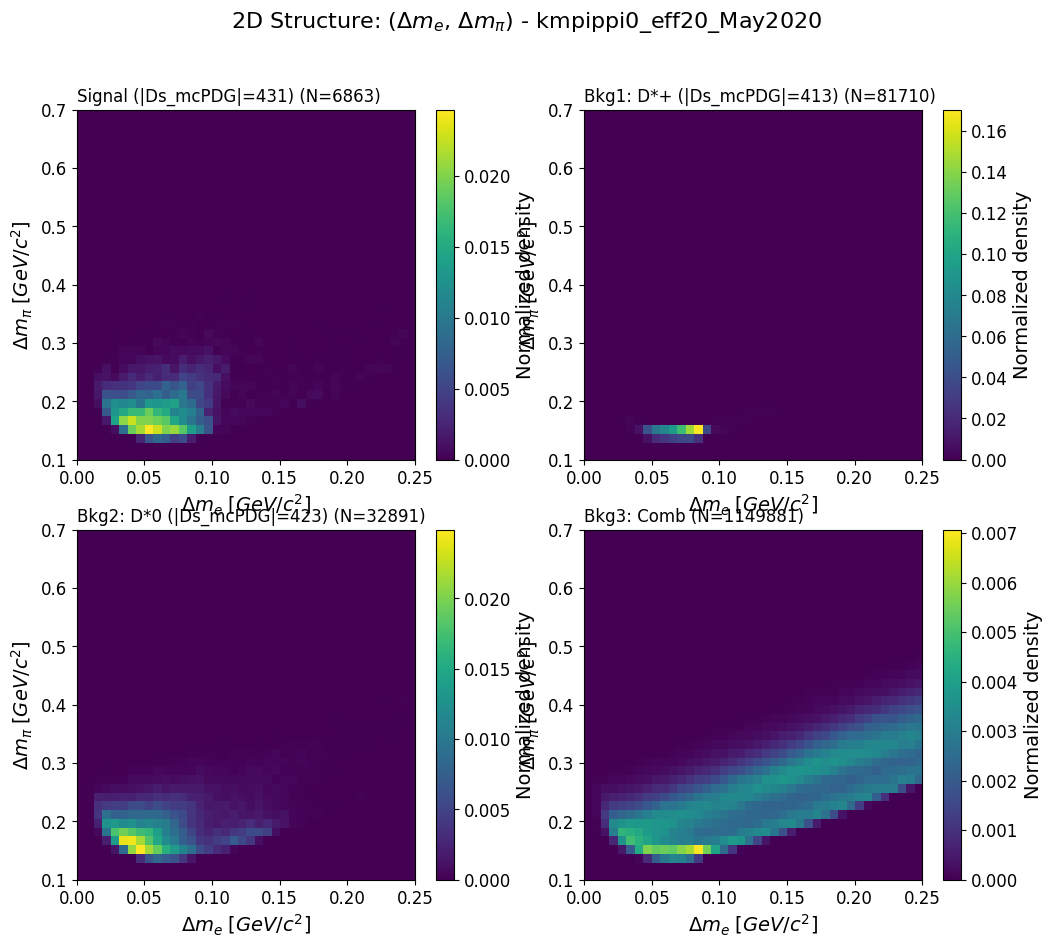

In [43]:
bins_2d = [40, 40]
range_2d = [[0.0, 0.25], [0.10, 0.70]]  # [Δm_e, Δm_π]

for mode in decay_config.keys():
    print(f"\n{'='*80}")
    print(f"2D Structure (Δm_e, Δm_π) - {mode}")
    print('='*80)

    df_sig = DataFrames[f"Signal_{mode}"].copy()
    df_bkg = DataFrames[f"All_{mode}"].copy()

    sig_mask = abs(df_sig['Ds_mcPDG']) == 431
    df_sig = df_sig[sig_mask]

    bkg1 = df_bkg[abs(df_bkg['Ds_mcPDG']) == 413].copy()
    bkg2 = df_bkg[abs(df_bkg['Ds_mcPDG']) == 423].copy()
    bkg3 = df_bkg[(abs(df_bkg['Ds_mcPDG']) != 413) &
                  (abs(df_bkg['Ds_mcPDG']) != 423)].copy()

    datasets = {
        'Signal (|Ds_mcPDG|=431)': df_sig,
        'Bkg1: D*+ (|Ds_mcPDG|=413)': bkg1,
        'Bkg2: D*0 (|Ds_mcPDG|=423)': bkg2,
        'Bkg3: Comb': bkg3
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (name, df) in enumerate(datasets.items()):
        if len(df) == 0:
            axes[idx].set_title(f'{name} (N=0)')
            continue

        H, xedges, yedges = np.histogram2d(
            df['Ds_massDifference_0'],  # Δm_e
            df['Ds_diff_D0pi'],         # Δm_π
            bins=bins_2d,
            range=range_2d
        )

        total = np.sum(H)
        if total > 0:
            H = H / total

        im = axes[idx].imshow(
            H.T,
            origin='lower',
            aspect='auto',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            cmap='viridis',
            interpolation='nearest'
        )

        axes[idx].set_xlabel(r'$\Delta m_e\;[GeV/c^{2}]$')
        axes[idx].set_ylabel(r'$\Delta m_\pi\;[GeV/c^{2}]$')
        axes[idx].set_title(f'{name} (N={len(df)})', loc='left')
        plt.colorbar(im, ax=axes[idx], label='Normalized density')

    plt.suptitle(f'2D Structure: ($\\Delta m_e$, $\\Delta m_\\pi$) - {mode}', fontsize=16)
    plt.show()